# AlphaZero in Conx

This notebook is based on:

* https://applied-data.science/blog/how-to-build-your-own-alphazero-ai-using-python-and-keras/
* https://github.com/AppliedDataSciencePartners/DeepReinforcementLearning

This code use the new [conx](http://conx.readthedocs.io/en/latest/) layer that sits on top of Keras. Conx is designed to be simpler than Keras, more intuitive, and integrated visualizations.

Currently this code requires the TensorFlow backend, as it has a function specific to TF.

In [1]:
import conx as cx
from keras import regularizers

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
conx, version 3.5.10


In [2]:
## NEED TO REWRITE THIS FUNCTION IN KERAS:

import tensorflow as tf

def softmax_cross_entropy_with_logits(y_true, y_pred):
    p = y_pred
    pi = y_true
    zero = tf.zeros(shape = tf.shape(pi), dtype=tf.float32)
    where = tf.equal(pi, zero)
    negatives = tf.fill(tf.shape(pi), -100.0) 
    p = tf.where(where, negatives, p)
    loss = tf.nn.softmax_cross_entropy_with_logits(labels = pi, logits = p)
    return loss

In [3]:
def add_conv_layer(net, input_layer):
    cname = net.add(cx.Conv2DLayer("conv2d-%d", 
                    filters=75, 
                    kernel_size=(4,4), 
                    data_format="channels_first", 
                    padding='same', 
                    use_bias=False,
                    activation='linear', 
                    kernel_regularizer=regularizers.l2(0.0001)))
    bname = net.add(cx.BatchNormalizationLayer("batch-norm-%d", axis=1))
    lname = net.add(cx.LeakyReLULayer("leaky-relu-%d"))
    net.connect(input_layer, cname)
    net.connect(cname, bname)
    net.connect(bname, lname)
    return lname

def add_residual_layer(net, input_layer):
    prev_layer = add_conv_layer(net, input_layer)
    cname = net.add(cx.Conv2DLayer("conv2d-%d",
        filters=75,
        kernel_size=(4,4),
        data_format="channels_first",
        padding='same',
        use_bias=False,
        activation='linear',
        kernel_regularizer=regularizers.l2(0.0001)))
    bname = net.add(cx.BatchNormalizationLayer("batch-norm-%d", axis=1))
    aname = net.add(cx.AddLayer("add-%d"))
    lname = net.add(cx.LeakyReLULayer("leaky-relu-%d"))
    net.connect(prev_layer, cname)
    net.connect(cname, bname)
    net.connect(input_layer, aname)
    net.connect(bname, aname)
    net.connect(aname, lname)
    return lname

def add_value_head(net, input_layer):
    l1 = net.add(cx.Conv2DLayer("conv2d-%d",
        filters=1,
        kernel_size=(1,1),
        data_format="channels_first",
        padding='same',
        use_bias=False,
        activation='linear',
        kernel_regularizer=regularizers.l2(0.0001)))
    l2 = net.add(cx.BatchNormalizationLayer("batch-norm-%d", axis=1))
    l3 = net.add(cx.LeakyReLULayer("leaky-relu-%d"))
    l4 = net.add(cx.FlattenLayer("flatten-%d"))
    l5 = net.add(cx.Layer("dense-%d",
        20,
        use_bias=False,
        activation='linear',
        kernel_regularizer=regularizers.l2(0.0001)))
    l6 = net.add(cx.LeakyReLULayer("leaky-relu-%d"))
    l7 = net.add(cx.Layer('value_head',
        1,
        use_bias=False,
        activation='tanh',
        kernel_regularizer=regularizers.l2(0.0001)))
    net.connect(input_layer, l1)
    net.connect(l1, l2)
    net.connect(l2, l3)
    net.connect(l3, l4)
    net.connect(l4, l5)
    net.connect(l5, l6)
    net.connect(l6, l7)
    return l7

def add_policy_head(net, input_layer):
    l1 = net.add(cx.Conv2DLayer("conv2d-%d",
        filters=2,
        kernel_size=(1,1),
        data_format="channels_first",
        padding='same',
        use_bias=False,
        activation='linear',
        kernel_regularizer = regularizers.l2(0.0001)))
    l2 = net.add(cx.BatchNormalizationLayer("batch-norm-%d", axis=1))
    l3 = net.add(cx.LeakyReLULayer("leaky-relu-%d"))
    l4 = net.add(cx.FlattenLayer("flatten-%d"))
    l5 = net.add(cx.Layer('policy_head',
            42,
            use_bias=False,
            activation='linear',
            kernel_regularizer=regularizers.l2(0.0001)))
    net.connect(input_layer, l1)
    net.connect(l1, l2)
    net.connect(l2, l3)
    net.connect(l3, l4)
    net.connect(l4, l5)
    return l5

In [ ]:
## TEMPORARY until we get it hooked up to the game engine:
from collections import namedtuple

Game = namedtuple("Game", ["ROWS", "COLUMNS"])
game = Game(ROWS=6, COLUMNS=7)

In [4]:
net = cx.Network("Residual CNN")
net.add(cx.Layer("main_input", (2, game.ROWS, game.COLUMNS)))
out_layer = add_conv_layer(net, "main_input")
for i in range(5):
    out_layer = add_residual_layer(net, out_layer)
add_policy_head(net, out_layer)
add_value_head(net, out_layer)

'value_head'

In [5]:
net.compile(loss={'value_head': 'mean_squared_error', 
                  'policy_head': softmax_cross_entropy_with_logits},
            optimizer=cx.SGD(lr=0.1, momentum=0.9),
            loss_weights={'value_head': 0.5, 
                          'policy_head': 0.5})

In [6]:
net.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 2, 6, 7)      0                                            
__________________________________________________________________________________________________
conv2d-1 (Conv2D)               (None, 75, 6, 7)     2400        main_input[0][0]                 
__________________________________________________________________________________________________
batch-norm-1 (BatchNormalizatio (None, 75, 6, 7)     300         conv2d-1[0][0]                   
__________________________________________________________________________________________________
leaky-relu-1 (LeakyReLU)        (None, 75, 6, 7)     0           batch-norm-1[0][0]               
__________________________________________________________________________________________________
conv2d-2 (

In [8]:
len(net.layers)

51

<IPython.core.display.Javascript object>


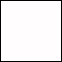
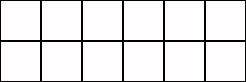
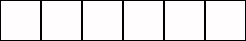
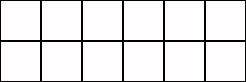
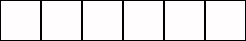
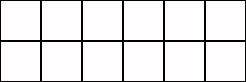
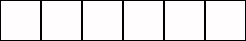
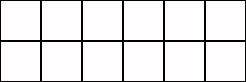

In [9]:
net.render(height="15000px")

In [11]:
import numpy as np
import random
v1 = cx.reshape([random.random() for x in range(2 * 2 * 6 * 7)], (2, 2, 6, 7))
output = net.propagate(v1, raw=True, visualize=True)
print(output)

[array([[ 0.12641619,  0.17715357, -0.10366092,  0.01087515, -0.02398484,
        -0.15189587, -0.11961485, -0.12405267,  0.01570394, -0.06041281,
         0.07187257,  0.10235301, -0.11428093, -0.02110442,  0.09882074,
         0.05649715,  0.09161995, -0.13220379, -0.02935239,  0.01048851,
         0.12660158,  0.09684212, -0.08626915, -0.0376628 , -0.02414796,
        -0.09389654,  0.02028242,  0.13464412,  0.12954113,  0.06635754,
         0.03824765,  0.08958779,  0.02209863,  0.08707005, -0.04197749,
        -0.13729972,  0.06747106, -0.03888379, -0.00706998, -0.07250959,
         0.12016027,  0.11405452],
       [ 0.12535903,  0.14761078, -0.14672425, -0.02745956, -0.04874171,
        -0.10589603, -0.01448227, -0.08594493, -0.0442402 ,  0.0205896 ,
        -0.00863478,  0.21248677, -0.16380951,  0.11845104,  0.01127811,
         0.11589967,  0.10917542, -0.07609208, -0.0227839 ,  0.07482741,
         0.11251296, -0.02703626,  0.00817305, -0.10145828, -0.03062505,
        -0.1369

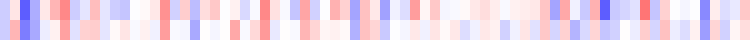

In [19]:
net.propagate_to_image("conv2d-1", v1, raw=True).resize((75 * 10, 2 * 20))

In [21]:
cx.shape(net.propagate_to("conv2d-1", v1, raw=True))

(2, 75, 6, 7)

### Output a diagram of the neural network architecture

In [23]:
from keras.utils import plot_model
plot_model(net.model, show_shapes=True, rankdir="BT")

<img src="model.png">